In [69]:
#import needed libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import os
import sklearn
import sklearn.model_selection
import sklearn.linear_model
import sklearn.svm
from scipy import stats
from urllib import request
from bs4 import BeautifulSoup
from sklearn.impute import SimpleImputer
import sklearn.ensemble
import sklearn.tree
from sklearn import metrics
from sklearn.metrics import confusion_matrix


In [374]:
#import data
diagnosis_dataset = pd.read_sas('hepatitisdata/HEQ_I.XPT')
#print(diagnosis_dataset.head())
occupation_dataset = pd.read_sas('hepatitisdata/OCQ_I.XPT')
#print(occupation_dataset.head())
dataset = pd.read_csv('nhanes_yrs5.csv')
# Write your code here

C:\Users\admin\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (4161,6598,6599,6601) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [375]:
#dropping unnecessary variables (don't worry about this)
dataset = dataset[dataset.columns.drop(list(dataset.filter(regex='WT')))]
dataset = dataset[dataset.columns.drop(list(dataset.filter(regex='SDM')))]

In [442]:
ind_names = {
    'RIDAGEYR': 'Age',
    'RIAGENDR': 'Gender',
    'RIDRETH1': 'Ethnicity',
    'LBXHIVC': 'HIV',
}

ind_vars = list(ind_names.keys())

dep_names = {
    'LBXHBC': 'Hepatitis B',
}

dep_vars = list(dep_names.keys())

all_names = {
    **dep_names,
    **ind_names,
}

all_vars = [*dep_vars, *ind_vars]

df = dataset.loc[:, list(all_names.keys())]

# Supplement missing data
def load_missing(code, url):
    miss_dat = pd.read_sas(url)
    df.loc[:, code] = miss_dat.loc[:, code]


load_missing('LBXHIVC', 'https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/HIV_I.XPT')
# Rename columns and display

df = df.rename(columns=all_names)

df.loc[:, 'Hepatitis B'] = 2 - df['Hepatitis B']
try:
    df.loc[:, 'Gender'] = df['Gender'] - 1
except KeyError:
    pass
df.head(20)

# Write your code here

# create a subset of the data you want to analyze

# rename the variables

Hepatitis B  Age  Gender  Ethnicity  HIV
0           0.0   62       1          5  2.0
1           0.0    6       1          5  2.0
2           0.0   71       0          3  2.0
3           NaN    1       1          3  2.0
4           0.0   52       0          1  2.0
5           NaN    6       0          1  2.0
6           NaN   21       0          4  2.0
7           0.0   64       0          1  2.0
8           0.0   66       0          4  2.0
9           NaN    0       0          3  2.0
10          0.0   30       1          2  2.0
11          0.0   61       1          1  NaN
12          1.0   27       0          5  2.0
13          NaN    5       0          1  2.0
14          0.0   40       1          1  2.0
15          0.0   66       1          4  2.0
16          0.0   11       1          3  2.0
17          0.0   72       0          3  2.0
18          0.0   77       1          3  2.0
19          0.0   40       0          1  2.0

In [443]:
try:
    df.loc[df['Alcohol'] > 15, 'Alcohol'] = df['Alcohol'].mean()
except KeyError:
    pass
df.describe()

Hepatitis B           Age        Gender     Ethnicity          HIV
count  7410.000000  10149.000000  10149.000000  10149.000000  3661.000000
mean      0.047503     32.967189      0.497882      2.766085     1.995356
std       0.212727     25.483639      0.500020      1.146737     0.067994
min       0.000000      0.000000      0.000000      1.000000     1.000000
25%       0.000000      9.000000      0.000000      2.000000     2.000000
50%       0.000000     29.000000      0.000000      3.000000     2.000000
75%       0.000000     55.000000      1.000000      4.000000     2.000000
max       1.000000     80.000000      1.000000      5.000000     2.000000

In [444]:
num_inf = df['Hepatitis B'].sum()
df[df['Hepatitis B'] == 0] = df[df['Hepatitis B'] == 0][:int(num_inf)]

for element in df.columns.values:
    df = df[df[element] == df[element]]

df.dropna()

Hepatitis B   Age  Gender  Ethnicity  HIV
0             0.0  62.0     1.0        5.0  2.0
1             0.0   6.0     1.0        5.0  2.0
2             0.0  71.0     0.0        3.0  2.0
4             0.0  52.0     0.0        1.0  2.0
7             0.0  64.0     0.0        1.0  2.0
8             0.0  66.0     0.0        4.0  2.0
10            0.0  30.0     1.0        2.0  2.0
12            1.0  27.0     0.0        5.0  2.0
14            0.0  40.0     1.0        1.0  2.0
15            0.0  66.0     1.0        4.0  2.0
16            0.0  11.0     1.0        3.0  2.0
17            0.0  72.0     0.0        3.0  2.0
18            0.0  77.0     1.0        3.0  2.0
19            0.0  40.0     0.0        1.0  2.0
21            0.0  64.0     1.0        1.0  2.0
23            0.0  68.0     0.0        4.0  2.0
24            0.0  17.0     1.0        1.0  2.0
25            0.0  14.0     1.0        1.0  2.0
26            0.0  70.0     0.0        3.0  2.0
27            0.0  29.0     0.0        1.0  2.0
28            0.0  18.0     0.0        3.0  2.0
29            0.0  63.0     0.0        3.0  2.0
32            0.0   6.0     1.0        4.0  2.0
34            0.0  48.0     0.0        2.0  2.0
35            0.0  33.0     1.0        3.0  2.0
36            0.0  35.0     0.0        1.0  2.0
37            0.0  80.0     1.0        3.0  2.0
38            0.0  80.0     1.0        2.0  2.0
39            0.0  70.0     0.0        3.0  2.0
41            0.0  74.0     1.0        3.0  2.0
...           ...   ...     ...        ...  ...
2799          1.0  38.0     0.0        3.0  2.0
2810          1.0  55.0     0.0        4.0  2.0
2813          1.0  51.0     0.0        4.0  2.0
2832          1.0  57.0     1.0        2.0  2.0
2843          1.0  31.0     1.0        5.0  2.0
2849          1.0  80.0     1.0        2.0  2.0
2852          1.0  54.0     1.0        5.0  2.0
2889          1.0  80.0     0.0        4.0  2.0
2938          1.0  53.0     0.0        1.0  2.0
2971          1.0  48.0     0.0        4.0  2.0
3006          1.0  51.0     1.0        2.0  2.0
3075          1.0  66.0     1.0        2.0  2.0
3097          1.0  60.0     1.0        4.0  2.0
3099          1.0  80.0     0.0        3.0  2.0
3153          1.0  80.0     1.0        3.0  2.0
3216          1.0  60.0     0.0        4.0  2.0
3217          1.0  49.0     1.0        3.0  2.0
3256          1.0  60.0     1.0        2.0  2.0
3338          1.0  46.0     0.0        5.0  2.0
3364          1.0  75.0     1.0        5.0  2.0
3411          1.0  51.0     0.0        5.0  2.0
3416          1.0  50.0     1.0        3.0  2.0
3523          1.0  46.0     1.0        2.0  2.0
3543          1.0  71.0     0.0        4.0  2.0
3662          1.0  51.0     1.0        4.0  2.0
3676          1.0  56.0     1.0        5.0  2.0
3809          1.0  53.0     1.0        5.0  2.0
3824          1.0  60.0     0.0        4.0  2.0
3859          1.0  71.0     0.0        4.0  2.0
3892          1.0  61.0     1.0        1.0  2.0

[445 rows x 5 columns]

In [445]:
df.describe()

Hepatitis B         Age      Gender   Ethnicity         HIV
count   445.000000  445.000000  445.000000  445.000000  445.000000
mean      0.276404   43.973034    0.469663    2.831461    1.993258
std       0.447723   23.169940    0.499641    1.183939    0.081922
min       0.000000    6.000000    0.000000    1.000000    1.000000
25%       0.000000   23.000000    0.000000    2.000000    2.000000
50%       0.000000   46.000000    0.000000    3.000000    2.000000
75%       1.000000   64.000000    1.000000    4.000000    2.000000
max       1.000000   80.000000    1.000000    5.000000    2.000000

In [446]:
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(
    df.iloc[:, 1:],
    df.iloc[:, 0]
)

In [447]:
model = sklearn.linear_model.LogisticRegression(solver='lbfgs')
model.fit(x_train, y_train)
y_pred = model.predict_proba(x_test)

In [448]:
def test_confusion(model, y_test, y_pred):
    
    confusions = confusion_matrix(y_test, y_pred)

    print(confusions)
    tpr = confusions[1, 1] / (confusions[1, 0] + confusions[1, 1])
    print(f'TPR: {tpr}')
    ppv = confusions[1, 1] / (confusions[1, 1] + confusions[0, 1])
    print(f'PPV: {ppv}')
    tnr = confusions[0, 0] / (confusions[0, 0] + confusions[0, 1])
    print(f'TNR: {tnr}')
    fnr = confusions[1, 0] / (confusions[1, 0] + confusions[1, 1])
    print(f'FNR: {fnr}')
    fpr = confusions[0, 1] / (confusions[0, 0] + confusions[0, 1])
    print(f'FPR: {fpr}')
    acc = (confusions[0, 0] + confusions[1, 1]) / (np.sum(confusions[:2, :2]))
    print(f'ACC: {acc}')
    odds = (confusions[0, 0] * confusions[1, 1]) / (confusions[0, 1] * confusions[1, 0])
    print(f'ODDS: {odds}')

In [449]:
def draw_roc(model, x_test, y_test):
    fig, ax = plt.subplots()
    y_pred = model.predict_proba(x_test)[:,1]

    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.plot(fpr, tpr)
    
    auc = metrics.roc_auc_score(y_test, y_pred)
    return auc

Score 0.7857142857142857


0.8265625000000001

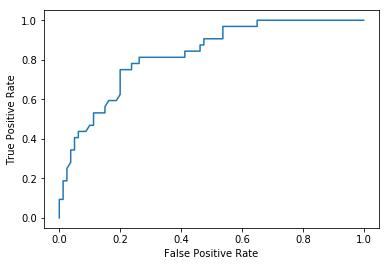

In [450]:
print('Score', model.score(x_test, y_test))
#test_confusion(model, y_test, y_pred)
draw_roc(model, x_test, y_test)

Score 0.8035714285714286
ROC 0.84921875


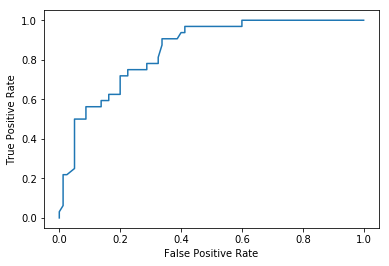

In [451]:
forest = sklearn.ensemble.RandomForestClassifier(min_samples_leaf=6, random_state=0, n_estimators=20)
forest.fit(x_train, y_train)
y_pred = forest.predict_proba(x_test)

print('Score', forest.score(x_test, y_test))
print('ROC', draw_roc(forest, x_test, y_test))


In [452]:
confusions = confusion_matrix(y_test, forest.predict(x_test))


print(confusions)
tpr = confusions[1, 1] / (confusions[1, 0] + confusions[1, 1])
print(f'TPR: {tpr}')
ppv = confusions[1, 1] / (confusions[1, 1] + confusions[0, 1])
print(f'PPV: {ppv}')
tnr = confusions[0, 0] / (confusions[0, 0] + confusions[0, 1])
print(f'TNR: {tnr}')
fnr = confusions[1, 0] / (confusions[1, 0] + confusions[1, 1])
print(f'FNR: {fnr}')
fpr = confusions[0, 1] / (confusions[0, 0] + confusions[0, 1])
print(f'FPR: {fpr}')
acc = (confusions[0, 0] + confusions[1, 1]) / (np.sum(confusions[:2, :2]))
print(f'ACC: {acc}')
odds = (confusions[0, 0] * confusions[1, 1]) / (confusions[0, 1] * confusions[1, 0])
print(f'ODDS: {odds}')

[[73  7]
 [15 17]]
TPR: 0.53125
PPV: 0.7083333333333334
TNR: 0.9125
FNR: 0.46875
FPR: 0.0875
ACC: 0.8035714285714286
ODDS: 11.81904761904762


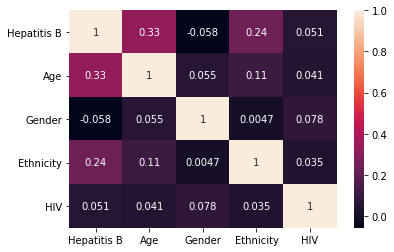

In [453]:
sns.heatmap(df.corr(), annot=True)